In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using nmAPG with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [L^2(0,1)]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|_2^2 + \frac{\vartheta}{2} \| \rho(T) - \widehat{\rho}(T) \|^2_{\R^3},
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameters $\theta$ and $\vartheta$ are non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha(t) = (\beta(t), \gamma(t),m(t)) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline, interp1d
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Data loading

We load data used in [[1]](https://doi.org/10.1007/978-981-19-7222-5_42) that can be accessed through: [[2]](https://drive.google.com/drive/folders/1w7XzmSNMVff8bUgqgMK2gY5d0a736JF_). Locally, we have stored data of susceptible, active, recovered, and deceased compartments from March 1 – April 30, 2020. The _active_ compartment contains all the different (recorded) infected cases at the time of data recollection. When constructing the dataset, the total population size $\mathsf{n}$ was set to 5\,850\,000 given by an estimate of the UN by mid 2020 [[3]](https://datos.bancomundial.org/indicador/SP.POP.TOTL?end=2023&locations=SG&start=2020). We will set $\mathsf{n}$ to be equal to the total number of people at the initial time.

In [4]:
loaded = np.load('SG_2020_Feb_Apr.npz')

In [5]:
SIRD = loaded['SG']
# Scale population: (helps in computation time)
SIRD *= 1e-4

The data considers reports spanning 60 days. We will group those observations by week and label the initial week by $0$; i.e., $T = 60/7 \approx 63/7 -1 = 8$:

In [6]:
T = SIRD.shape[0]/7.0
#Tᵇᵃˢᵉ = arange(0,T+1)
Tᵒᵇˢ  = linspace(0,T,SIRD.shape[0])

We build a piecewise interpolator for computing any integral terms:

In [7]:
Tₑ = 0.5*(chebpts1(142-2)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])       # Add endpoints
# Add observed points
Tₑ = np.unique(np.sort(concatenate([Tₑ,Tᵒᵇˢ])))

In [8]:
ρ̄ = interp1d(Tᵒᵇˢ,SIRD[:,:-1].T, axis=-1)
ρ̂ = ρ̄(Tₑ)

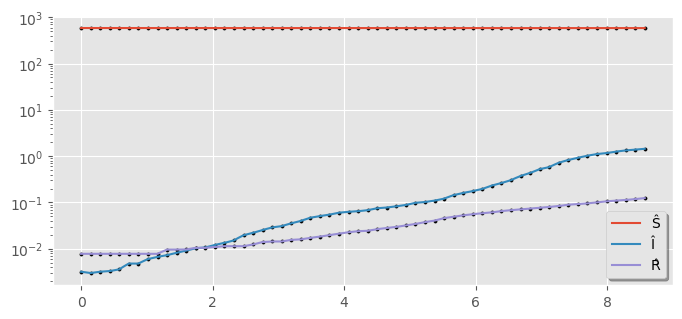

In [9]:
# Plot data
plt.figure(figsize=(8,3.5))

plt.plot(Tₑ,ρ̂.T)
plt.scatter(Tᵒᵇˢ,SIRD[:,0],s=5, c='black')
plt.scatter(Tᵒᵇˢ,SIRD[:,1],s=5, c='black')
plt.scatter(Tᵒᵇˢ,SIRD[:,2],s=5, c='black')

plt.yscale('log')

plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.show()

# Problem setup

In [10]:
# Total population
n = ρ̄(0).sum()
# Initial conditions
ρ̂ₒ = ρ̄(0)
# Final time
ρ̂ᶠ = ρ̄(T)

In [11]:
θ,ϑᵀᵉʳ = 1e-6, 0.1

In [12]:
θ = np.asarray([1e-6,1e-9,1e-9])[::,np.newaxis]

## Differential systems

We define a class in order to quickly get and modify $\alpha$.

In [13]:
class Arg:
    def __init__(self,val=1.0):
        # Check if the input is a scalar or an array-like object
        if np.isscalar(val):
            # If scalar, create an array of ones multiplied by the scalar
            self.data = val * ones([3,Tₑ.size],dtype=float);    self.interp = lambda t: val * asarray([1,1,1]);    self.En = 3 * (val**2) * T
            self.Ens = (val**2) * T * ones([1,3])
        else:
            # If it's not a scalar, attempt to convert it to a numpy array
            self.data = asarray(val)
            # Ensure that the array has the correct shape
            if self.data.shape != (3,Tₑ.size):
                raise ValueError("Wrong input data size.")
            # Add interpolator and compute energy norm
            self.interp = self.sinterp();
            # Compute each norm
            self.En_Norm();            self.En = self.Ens.sum()
        
    # Describe
    def __str__(self):        return f'Function with discrete values stored in {self.data.shape} array.'
    # Print
    def printer(self):        print(self.data);
    # Copy
    def copy(self):           return Arg(self.data.copy())
    # Vectorise
    def ravel(self):          return self.data.ravel()
    # Transpose means: get data
    @property
    def T(self):
        return self.data.T
    
    
    '''
        In-place updates
    '''
    # Set interpolator
    def sinterp(self):                     return interp1d(Tₑ, self.data, axis=-1)
    # Update interpolator
    def uinterp(self):                     self.interp = interp1d(Tₑ, self.data, axis=-1)
    # Compute squared L^2 norm
    def En_Norm(self):                     self.Ens = simpson(self.data**2, x = Tₑ)
    # Updates (adition and set value)
    def add(self, value):              self.data += value;        self.uinterp();        self.En_Norm()
    def update(self,value):            self.data  = value;        self.uinterp();        self.En_Norm()
        
    '''
        Operations
    '''
    # Dot product
    def dot(self,value):
        if isinstance(α, Arg):
            return (self.data * value.data).sum()
        else:
            return (self.data * value).sum()
    # Override the __array__ method to return self.data when treated like an array
    def __array__(self):
        return self.data
    # ** To compute the ℓ_2 norm, just run norm(Arg_instance, ord='fro')    or   (α.data.ravel()**2).sum()**0.5
    
    ''' Creation of new elements from old elements '''
    # Addition: Arg + Arg should return a new Arg instance
    def __add__(self, other):
        if isinstance(other, Arg):
            # Create a new Arg instance with the sum of the data
            new_data = self.data + other.data
            return Arg(new_data)
        else:
            new_data = self.data + other
            return Arg(new_data)

    # Pointwise multiplication: Arg * s should return a new Arg instance
    def __mul__(self, other):
        if isinstance(other, Arg):
            new_data = self.data * other.data
            return Arg(new_data)
        else:
            # Attempt to multiply
            new_data = self.data * other
            return Arg(new_data)

    # Reverse multiplication to support s * Arg
    def __rmul__(self, other):
        return self.__mul__(other)
    
    # Subtraction: Arg - s should return a new Arg instance
    def __sub__(self, other):
        if isinstance(other, Arg):
            new_data = self.data - other.data
            return Arg(new_data)
        else:
            # Attempt to subtract
            new_data = self.data - other
            return Arg(new_data)
    def __rsub__(self, other):
        return self.__sub__(other)

In [14]:
α = Arg(1.0)

In [15]:
print(α)

Function with discrete values stored in (3, 200) array.


Instantiate class with a smooth curve sampled from a Gaussian process:

In [16]:
from sklearn.metrics.pairwise import rbf_kernel
# Adapted a very nice idea from: https://gist.github.com/neubig/e859ef0cc1a63d1c2ea4

In [17]:
Sampled = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = 3 )
Sampled = 0.01 * (0.5 * (Sampled.T - Sampled.min())/np.ptp(Sampled) + 0.25)
# First curve should lie in [0,1e-2]:
if Sampled[:,0].max() > 1e-2:
    Sampled[:,0] *= 1e-2/Sampled[:,0].max()
# Check if m + γ ≤ 1
if Sampled[:,1:].sum(1).max() > 1:
    raise 'Scale (γ,m)'

In [18]:
α = Arg(Sampled.T)

Reproduction number associated with initial guess:

In [19]:
print('Basic reproduction number:', n * α.interp(0)[0]/α.interp(0)[1:].sum())

Basic reproduction number: 190.95285502133996


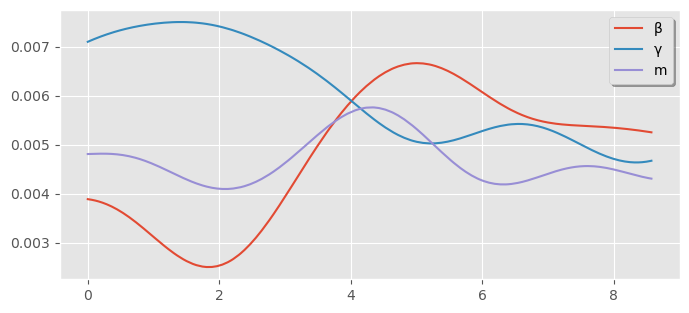

In [20]:
# Plot initial point
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, α.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.show()

## Solve a state:

In [21]:
def SIRD(t, z,  α_interp):
    β, γ, m = α_interp(t)    # Use interpolator
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [22]:
sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=[α.interp], t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


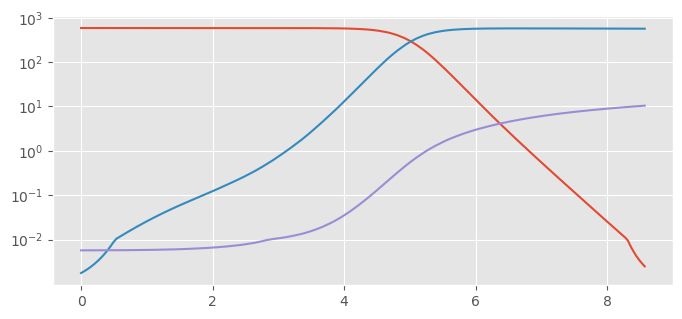

In [23]:
# Plot solution:
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ,sol.y.T)
plt.yscale('symlog', linthresh=1e-2)
#plt.xscale('symlog', linthresh=1e-2)

## Solve its adjoint

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = \vartheta\big[\rho(T) - \widehat{\rho}(T)\big]$.

In [24]:
# Interpolator from ODE
ρₜ = sol.sol
ρ = sol.y

In [25]:
def Adjoint(t, z, α_interp,ρ):
    β, γ, m = α_interp(t)    # Use interpolator
    S̄, Ī, R̄ = ρ̄(t)           # Target
    S, I, R = ρ(t)           # State
    qₛ, qᵢ, qᵣ = z           # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

In [26]:
qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)
solₛ = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
q = solₛ.y[:,::-1]
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 110 function evaluations.


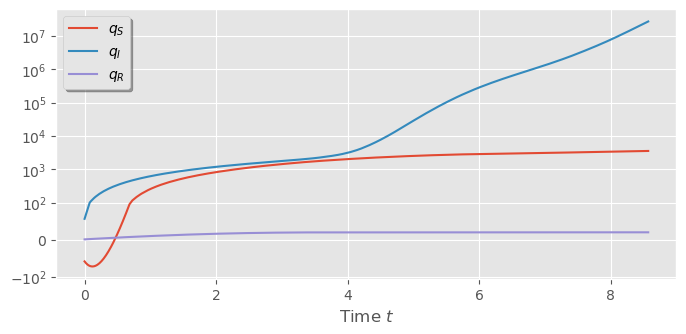

In [27]:
# Plot adjoint curves
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ[::-1],q.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.yscale('log')
plt.yscale('symlog', linthresh=1e+2)
plt.show()

## Cost and gradient

Now we try to optimise the function
\begin{align}
    j(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 + \frac{1}{2} \big( \theta_1 \beta^2(t) + \theta_2 \gamma^2(t) + \theta_3 m^2(t) \big) + H\big(\alpha(t) \big) \,\dif t  + \frac{1}{2} \| \vartheta (\rho(T) - \widehat{\rho}(T)) \|^2_{\R^3}
    .
\end{align}

In [28]:
# Define penalty function and its derivative
H_s  = lambda s: 1e+3 * np.where(s > 0.0, s**2, 0.0)
dH_s = lambda s: 1e+3 * np.where(s > 0.0, 2*s, 0.0)

In [29]:
def Objective(ρ,ρ̂,α, θ,ϑᵀᵉʳ):
    # State + controls
    scaling = True
    s  = simpson((ρ-ρ̂)**2, x=Tₑ).sum()  +  (ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)**2).sum()
    s /= (n**2) if scaling else 1.0
    # Controls
    s +=  (α.Ens * θ.T).sum()
    # Weight and add penalty
    return 0.5 * s  +  simpson( H_s( α.data[1,:] + α.data[2,:] - 1.0/7 ), x = Tₑ)

In [30]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format(  Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ) ))

As an example, the distance between ρ and ρ̂ is 3.3213.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &=  S I( q_I - q_S )  + \theta_1 \beta
    \\
    \frac{\partial f}{\partial \gamma} &=  I( q_R - q_I )   + \theta_2 \gamma   + 2\lambda \max\{0, \gamma + m -1 \}
    \\
    \frac{\partial f}{\partial m} &=  -I q_I    + \theta_3 m   + 2\lambda \max\{0, \gamma + m -1 \}
\end{align}

In [31]:
df = asarray([ρ[0]*ρ[1] * (q[1]-q[0]), 
              ρ[1] * (q[2]-q[1]) + n**2*dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
              -ρ[1] * q[1] + n**2*dH_s(α.data[1,:] + α.data[2,:] - 1.0/7) ])/(n**2)  + θ * α.data

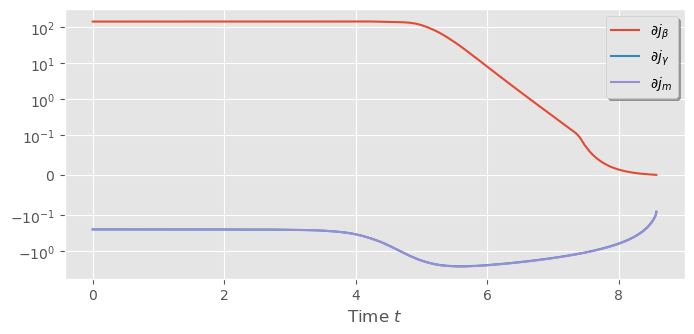

In [32]:
# Plot derivative
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ,df.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$\partial j_β$', '$\partial j_γ$', '$\partial j_m$'], shadow=True)
#plt.yscale('log')
plt.yscale('symlog', linthresh=1e-1)
plt.show()

### Define projection

In [33]:
upper_b = np.asarray([1e-2/7,1.0/7,1.0/7])[::,np.newaxis]

In [34]:
def proj(α):    return Arg(np.clip(α, 0.0, upper_b))

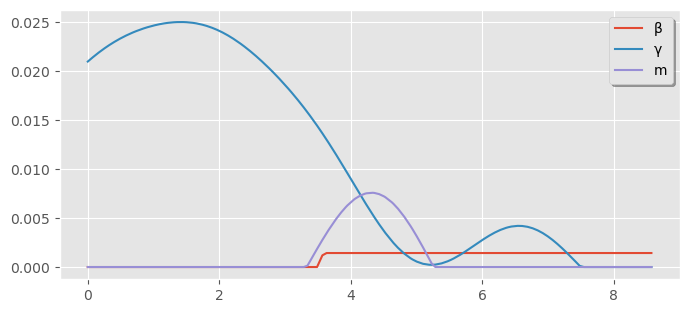

In [35]:
# Test projection
plt.figure(figsize=(8,3.5))
plt.plot(Tₑ, proj( 1e+1*(α-0.005) ).data.T)
plt.legend(['β', 'γ', 'm'], shadow=True)
plt.show()

# A few evaluations

Let us evaluate the objective for some curves:

In [36]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [37]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
        
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    return asarray(f)

def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], ρ̂ₒ, args=(α.interp,), t_eval = Tₑ, dense_output=True, vectorized=True, first_step = 0.1)
    if ρ_sol['success'] != True:    print('Should re-evaluate.')
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂, α, θ, ϑᵀᵉʳ)
    
    # Create an abstract interpolator for state
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    qₒ = ϑᵀᵉʳ * (ρ[:,-1] - ρ̂ᶠ)    # Terminal condition
    q_sol = solve_ivp(Adjoint, [T,0], qₒ, args=(α.interp,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    s = (1.0/(n**2)) if scaling else 1.0
    df = asarray([ s * ρ[0]*ρ[1] * (q[1]-q[0]), 
                   s * ρ[1] * (q[2]-q[1])      + dH_s(α.data[1,:] + α.data[2,:] - 1.0), 
                  -s * ρ[1] * q[1]             + dH_s(α.data[1,:] + α.data[2,:] - 1.0) ])
    df += (θ * α.data)
    
    return asarray(f), df

In [38]:
obj_eval_a(α)

array(3.32124131)

---

In [39]:
Samples = rng(2024).multivariate_normal( 0.0*Tₑ, rbf_kernel(Tₑ[::,np.newaxis], gamma = 0.25), size = (20,3) )
Samples = 0.01 * (0.5 * (np.transpose(Samples, (0, 2, 1)) - Samples.min())/np.ptp(Samples) + 0.25)

In [40]:
#Samples[:,:,0].max() > 1e-2   # returns false
#(Samples[:,:,1:].sum(2) > 1).any()   # same

In [41]:
Misfit = zeros([20,1])
for i in range(20):
    Misfit[i] = obj_eval_a(Arg(Samples[i].T))

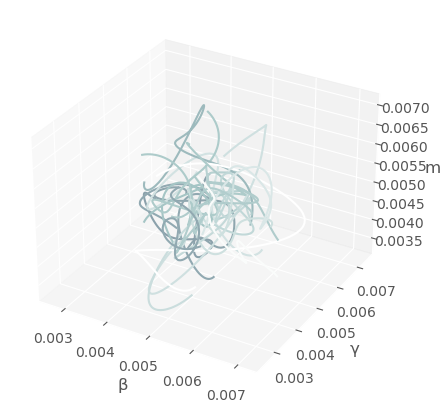

In [42]:
# Coarse sample
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure( figsize=(5, 11) )
ax = fig.add_subplot(111, projection='3d')

# Plot each curve with colors reflecting the Misfit values
for i, curve in enumerate(Samples):
    x = curve[:, 0]  # X coordinates
    y = curve[:, 1]  # Y coordinates
    z = curve[:, 2]  # Z coordinates
    
    # Get the color for the current curve based on the Misfit value
    color = colormaps['bone'](Misfit[i]/Misfit.max())
    
    # Plot the curve in 3D with the corresponding color
    ax.plot(x, y, z, c = color)

# Set labels for the axes
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('m')
ax.set_xlim([ max(0, Samples[:,:,0].min()), min(1e-2, Samples[:,:,0].max() ) ])
ax.set_xlim([ max(0, Samples[:,:,1].min()), min(1, Samples[:,:,1].max() ) ])
ax.set_zlim([ max(0, Samples[:,:,2].min()), min(1, Samples[:,:,2].max() ) ])

ax.set_facecolor('xkcd:white')
ax.set_box_aspect((1, 1, 0.75))
# Show the plot
plt.show()

In [43]:
print('Smallest objective found in the sample: {0};'.format(Misfit.min()) )

Smallest objective found in the sample: 3.0723899549375466;


# Solving the optimisation problem

We will use a gradient-based algorithm for optimising $f$. For any $L > 0$, and $\omega \in [0,1]^2$, define the the operator
$$
    p_L (\omega) := \mathcal{P}_{[0,1]^2}[\omega - L^{-1} \nabla f(\omega) ].
$$

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Nonmonotone Accelerated Proximal Gradient Algorithm</h2>
<ol>
<li>Let $\alpha_0 = \alpha_1 = \omega_1 = \nu_1 \in [0,1]^2$, $\theta_0 = 0$, $\theta_1 = 1$, $\mu \in [0,1)$, $\delta >0$, $\eta > 1$, $c_1 = j(\alpha_1)$, $\lambda_1 = 1$.</li>

    
<li>For $k \in \{1,\ldots\}$, do
<ol>
<li>Set 
    \begin{align*}
        \nu_{k} &= \alpha_k + \frac{\theta_{k-1}}{\theta_k} (\omega_k - \alpha_k) + \frac{\theta_{k-1} -1 }{\theta_k} (\alpha_k - \alpha_{k-1}) 
    \\
        s_{k} &= \nu_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\nu_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    
    
<li>Find the smallest $i_k \in \mathbb{N}$ such that
    \begin{align*}
        L &= \eta^{i_k} L_k
        \\
        \omega_{k+1} &= \mathcal{P} (\nu_k - L^{-1} \nabla j(\nu_k) ) = p_L(\nu_{k})
        \\
    j(\omega_{k+1}) &\leq \max\{c_k,j(\nu_k)\} - \delta \| \omega_{k+1} - \nu_k \|^2
    \end{align*}

    
<li> If $j(\omega_{k+1}) \leq c_k - \delta \| \omega_{k+1} - \nu_k \|^2$, then:
    <ol> 
        <li> $\alpha_{k+1} = \omega_{k+1}$
    </ol>
<li>Else:
    <ol>
        <li> Set 
    \begin{align*}
        s_{k} &= \alpha_k - \nu_{k-1}
        \qquad
        r_k = \nabla j(\alpha_k) - \nabla j(\nu_{k-1})
    \\
        L_k &= \mathcal{P}_{[10^{-20},10^{20}]} \left( \frac{s_k^\top r_k}{s_k^\top s_k} \right)  
    \end{align*}
    <li>Find the smallest $i_k \in \mathbb{N}$ such that
        \begin{align*}
            L &= \eta^{i_k} L_k
            \\
            \xi_{k+1} &= \mathcal{P} (\alpha_k - L^{-1} \nabla j(\alpha_k) ) = p_L(\alpha_{k})
            \\
        j(\xi_{k+1}) &\leq c_k - \delta \| \xi_{k+1} - \alpha_k \|^2
    \end{align*}
        <li> Assign
            \begin{align*}
                \alpha_{k+1} = \begin{cases}
                                    \omega_{k+1} &\text{if }  j(\omega_{k+1}) \leq j(\xi_{k+1}),
                                    \\
                                    \xi_{k+1} &\text{otherwise}.
                               \end{cases}
            \end{align*}
    </ol>
<li> Update $\theta_{k+1} = \frac{1}{2} \Big[ 1 + \sqrt{ 1 + 4 \theta_k^2 } \Big]$
<li> Update $\lambda_{k+1} = \mu \lambda_k + 1$
<li> Update $c_{k+1} = \lambda_{k+1}^{-1} \big[ \mu \lambda_k c_k + j(\alpha_{k+1}) \big]$

</ol>
</div>

In [44]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [45]:
def nmAPG(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 5e-13, print_tests = False):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    best = {'obj': 1e+10, 'α': None, 'df': None}
    
    '''
        Iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    ''' 
        Initialisation
    '''
    # Iterate, interpolation, proximal points
    αₒ = α.copy();    νₒ = α.copy();    ωₒ = α.copy()

    θₖ = 1.0;    θₒ = 0.0      # Inertia parameter (not to be confused with θ)
    μ = 0.004 #0.001    # Degree of nonmonotonicity
    η = 2.5 #2.5     # Scaling for backtracking
    δ = .5e-5         # Sufficient decrease
    I = 10            # Number of iterations for line search
    
    # First objective evaluation
    # Compute state and adjoint for α
    jα, djα = obj_eval(α)
    djνₒ = djα.copy()
    # Initial evaluation
    c = jα;    jαₒ = 0.0
    λ = 1.0
    
    print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(0, jα, 0.0, norm(djα.ravel())/(3*T**0.5), norm(djα.ravel(),np.inf) ))

    # Store info for initial point
    if save_iter:
        every_iter['it'].append( 0 )
        every_iter['obj'].append( jα )
        every_iter['time'].append( 0.0 )
        # Store norms of gradient
        every_iter['norms']['ℓ_2'].append( norm(djα.ravel())/(3*T**0.5) )
        every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(djα.ravel(),1) )
        every_iter['norms']['max'].append( norm(djα.ravel(), np.inf) )
        every_iter['norms']['min'].append( abs(djα.ravel()).min() )
        # Store best point
        if jα < best['obj']:
            best['obj'] = jα
            best['α']  =   α.copy()
            best['df'] = djα.copy()
    
    timed = 0.0
    for k in range(1,iters+1):
        it_time = time.time()
        
        # ------------ Step 1 ------------ #
        # Compute 
        ν = α + (θₒ/θₖ) * (ωₒ - α) + ((θₒ - 1.0)/θₖ) * (α - αₒ)
        if print_tests:            print( (1,k), ν.En) 
        # Project points just in case and evaluate objective and gradient
        ν = proj(ν)
        jν, djν = obj_eval(ν)
        if print_tests:            print( (1,k), jν )
        # Barzilai–Borwein
        s = ν - νₒ;             r = djν - djνₒ
        #print(k, s.dot(r)/s.dot(s), r.dot(r)/s.dot(r))
        L = 1 if k == 1 else s.dot(r)/s.dot(s)
        L = min( max(1e-20, L), 1e20)
        # Go one step ahead: if ν - b * djν goes too far, backtracking will waste time!
        bₜ = box_scale(ν.data,djν)
        L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
        
        # ------------ Step 2 ------------ #
        for i in range(I):
            # Temporary approximation of Lipschitz constant
            Lₓ = η**i * L;        b = 1.0/Lₓ
            # Gradient and proximal step
            ω = proj(ν - b * djν)
            # Evaluate objective at ω
            jω = obj_eval_a(ω)
            # Validate step
            if print_tests:            print( (2,k,i), ω.En,jω) 
            if (jω + δ * norm((ν - ω).data.ravel())**2) <= max(jν,c):
                break
            
        # ------------ Step 3 ------------ #
        if (jω + δ * norm((ν - ω).data.ravel())**2) <= c:
            αₒ = α.copy()
            α  = ω.copy()
        else:
            # Barzilai–Borwein
            s = α - νₒ;             r = djα - djνₒ
            L = s.dot(r)/s.dot(s)
            L = min( max(1e-20, L), 1e20)
            #print(s.dot(s), L)
            
            ''' Line search for interpolation '''
            # Go one step ahead: if α - b * djα goes too far, backtracking will waste time!
            # For any component without a zero gradient, the value of b has to satisfy 
            #    b ∈ [(α-1)/djα, α/djα] if djα > 0   and  [α/djα, (α-1)/djα]  if djα < 0
            # Thus the largest b satisfying these conditions is the minimum upper bound of each interval
            #
            bₜ = box_scale(α.data,djα)
            # Now we can either fix I or change L:
            L = L if bₜ < 1e-20 else max(L, 1.0/bₜ)
            
            for i in range(I):
                # Temporary approximation of Lipschitz constant
                Lₓ = η**i * L;        b = 1.0/Lₓ
                # Gradient and proximal step
                ξ  = proj(α - b * djα)
                # Evaluate objective at ω
                jξ = obj_eval_a(ξ)
                # Validate step
                if print_tests:            print( (3,k,i), ω,jω) 
                if (jξ + δ * norm((ξ - α).data.ravel())**2) <= c:
                    break
                    
            # Asign next step
            αₒ = α.copy()
            α = ω.copy() if (jω <= jξ) else ξ.copy()
            if print_tests:            print( (4,k), α.En,jα)
            
        # ------------ Step 4 ------------ #
        # Update objective and previous steps
        jαₒ = jα
        jα, djα = obj_eval(α)
        ωₒ = ω.copy()
        νₒ = ν.copy();        djνₒ = djν.copy()
        
        # Update inertia weights
        θₒ = θₖ
        θₖ = 0.5 * (1.0 + (1.0 + 4.0 * θₖ**2)**0.5)
        if print_tests:            print( (4,k),θₖ,θₒ)
        # Update exponential convex combination of objectives (19 in Li & Lin 2015)
        c = ((μ * λ * c) + jα)/ ((μ * λ) + 1)
        λ = (μ * λ) + 1
        if print_tests:            print( (4,k),c,λ)
        
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time        
        
        if save_iter:
            every_iter['it'].append( k )
            every_iter['obj'].append( jα )
            every_iter['time'].append( timed )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(djα.ravel())/(3*T**0.5) )
            every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(djα.ravel(),1) )
            every_iter['norms']['max'].append( norm(djα.ravel(), np.inf) )
            every_iter['norms']['min'].append( abs(djα.ravel()).min() )
            # Update point if needed
            if jα < best['obj']:
                best['obj'] = jα
                best['α']  =   α.copy()
                best['df'] = djα.copy()
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( jα )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(djα.ravel())/(3*T**0.5) )
            every_critical['|df|_max'].append( norm(djα.ravel(), np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k, jα, timed,
                                                                        norm(djα.ravel())/(3*T**0.5), norm(djα.ravel(), np.inf) ))
        
        if abs(jα - jαₒ) < εᵦ and k > 10:
            print('|j-jₖ| < {0:1.0e}'.format(εᵦ))
            #print(α)
            break
        
        if norm(α - αₒ, ord='fro')/(3*T**0.5) < εₐ:
            print('‖αₖ - p‖ < {0:1.0e}'.format(εₐ))
            #print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    # Due to nonmonoticity, last iterate is not necessarily the best candidate
    idx = np.argmin(every_iter['obj'])
    α = best['α']
    jα = obj_eval_a(α)
    print(α.En, jα)
    
    return α, ρ, every_critical, every_iter, best

In [46]:
#θ,ϑᵀᵉʳ = 1e-6, 0.1
#θ,ϑᵀᵉʳ = 1e-13, 1e+2

In [47]:
ϑᵀᵉʳ = np.asarray([1e-4,1e-4,5e+2])
θ = np.asarray([1e-6,1e-8,1e-9])[::,np.newaxis]

In [48]:
upper_b = np.asarray([1e-2/7,0.7/7,0.5/7])[::,np.newaxis]

In [49]:
ᾱ, ρ, every_critical, every_iter, best = nmAPG(α, 5000, save_iter = True, critical = 10, εₐ = 1e-13, εᵦ = 1e-13, print_tests = False);

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  3.3e+00 |     0.00  | 1.855e+02   |   1.537e+02  
*     10 |  9.4e-07 |     0.16  | 2.033e-04   |   3.671e-04  
*     20 |  7.2e-07 |     0.38  | 1.516e-04   |   2.475e-04  
*     30 |  6.5e-07 |     0.67  | 1.133e-04   |   9.731e-05  
*     40 |  6.2e-07 |     1.10  | 4.444e-04   |   3.557e-04  
*     50 |  5.8e-07 |     1.39  | 1.563e-04   |   1.393e-04  
*     60 |  5.7e-07 |     1.82  | 5.121e-04   |   4.089e-04  
*     70 |  5.7e-07 |     2.24  | 9.339e-05   |   1.191e-04  
*     80 |  5.6e-07 |     2.62  | 1.598e-04   |   1.426e-04  
*     90 |  5.6e-07 |     2.95  | 7.744e-05   |   9.917e-05  
*    100 |  5.8e-07 |     3.36  | 6.420e-04   |   5.047e-04  
*    110 |  5.7e-07 |     3.66  | 3.752e-04   |   3.095e-04  
*    120 |  5.3e-07 |     4.02  | 3.500e-04   |   2.804e-04  
*    130 |  5.1e-07 |     4.29  | 1.323e-04   |   1.135e-04  
*    14

In [50]:
simpson((ρ-ρ̂)**2, x=Tₑ).sum()/(n**2),  ϑᵀᵉʳ * ((ρ[:,-1] - ρ̂ᶠ)**2).sum()/(n**2), (ᾱ.Ens), simpson( H_s( ᾱ.data[1,:] + ᾱ.data[2,:] - 1.0/7 ), x = Tₑ)

(1.0900432868809489e-07,
 array([5.78883044e-13, 5.78883044e-13, 2.89441522e-06]),
 array([1.66073767e-05, 3.58284966e-02, 1.11479330e-02]),
 0.0)

In [51]:
((ρ[:,-1] - ρ̂ᶠ))

array([-0.01179711, -0.04291498,  0.0004653 ])

---

In [52]:
#CMap = get_cmap('Wistia')
CMap = colormaps['BuGn']
colours_nmAPG = CMap(150)

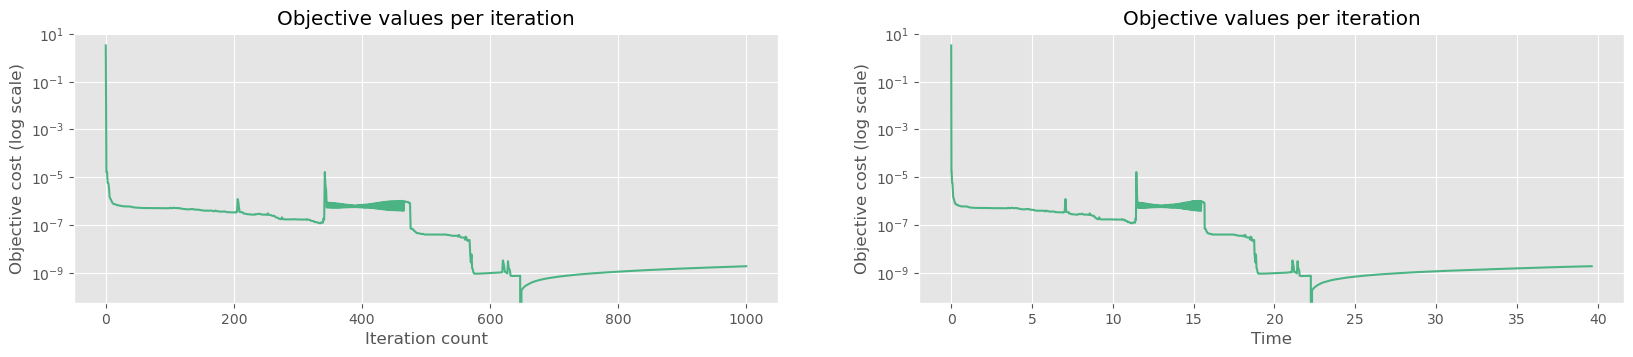

In [53]:
# Visualise evolution of objective values
plt.figure(figsize = (20,3.5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']), c = colours_nmAPG)
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

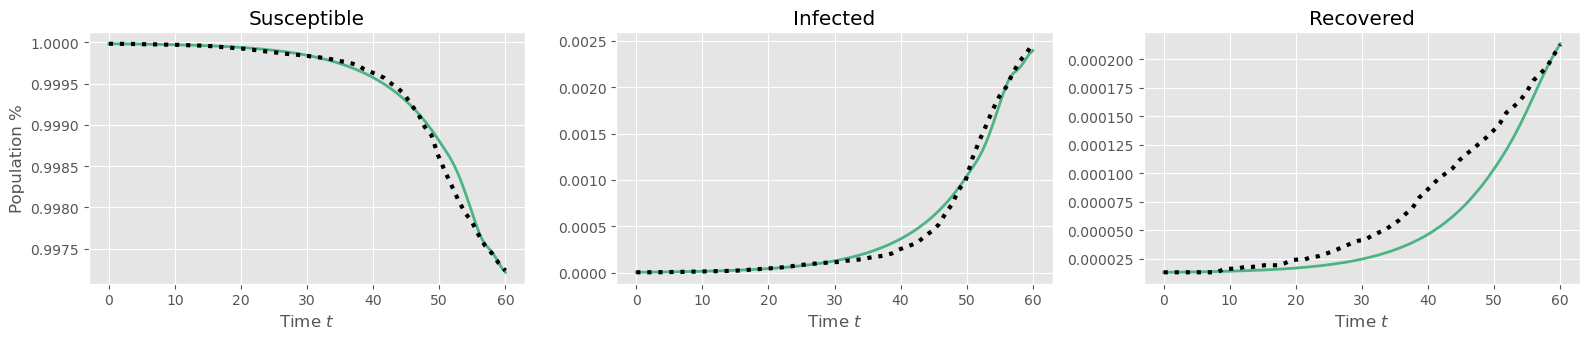

In [54]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ρ[0]/n, '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, ρ[1]/n, '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, ρ[2]/n, '-', c=colours_nmAPG, linewidth=2)
    
# Add target
ax[0].plot(Tₑ*7, ρ̂[0]/n, ':', c='black', linewidth=3)
ax[1].plot(Tₑ*7, ρ̂[1]/n, ':', c='black', linewidth=3)
ax[2].plot(Tₑ*7, ρ̂[2]/n, ':', c='black', linewidth=3)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [55]:
obj_eval(ᾱ);

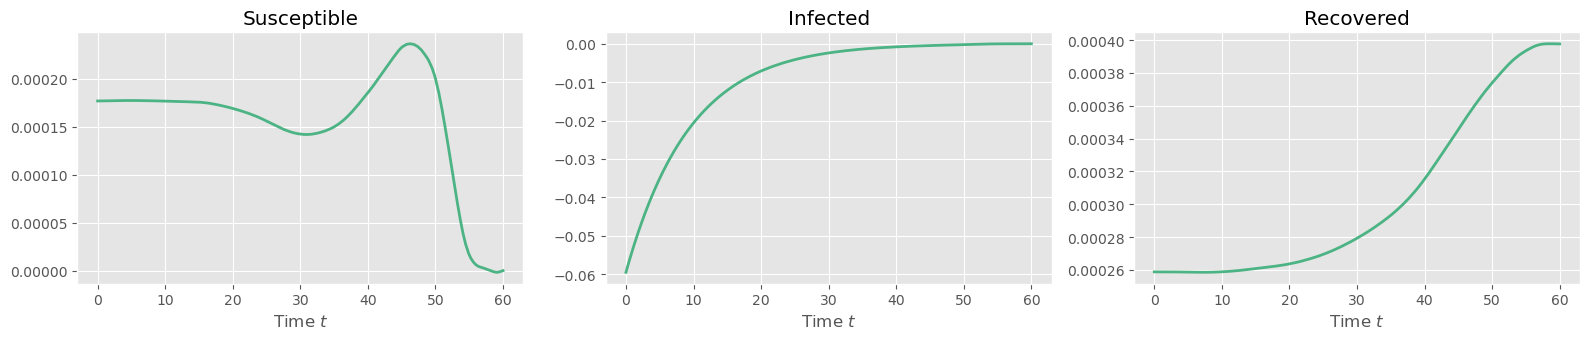

In [56]:
# Plot adjoint
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, q[0]/n, '-', c=colours_nmAPG, linewidth=2)
ax[1].plot(Tₑ*7, q[1]/n, '-', c=colours_nmAPG, linewidth=2)
ax[2].plot(Tₑ*7, q[2]/n, '-', c=colours_nmAPG, linewidth=2)
    

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')



#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

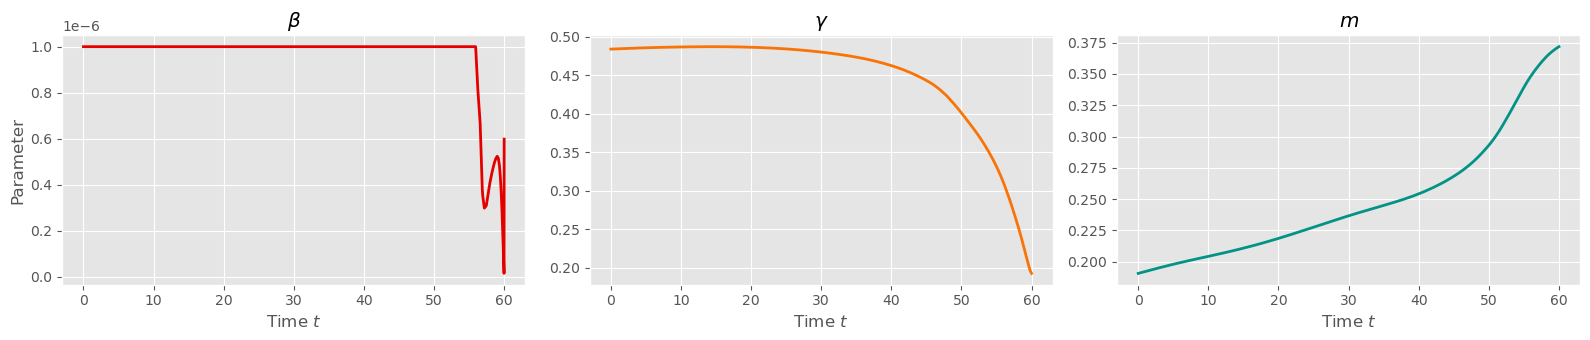

In [57]:
# Plot control 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, ᾱ.data[0]*7*1e-4, '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*7, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, ᾱ.data[2]*7, '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\beta$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\gamma$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$m$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

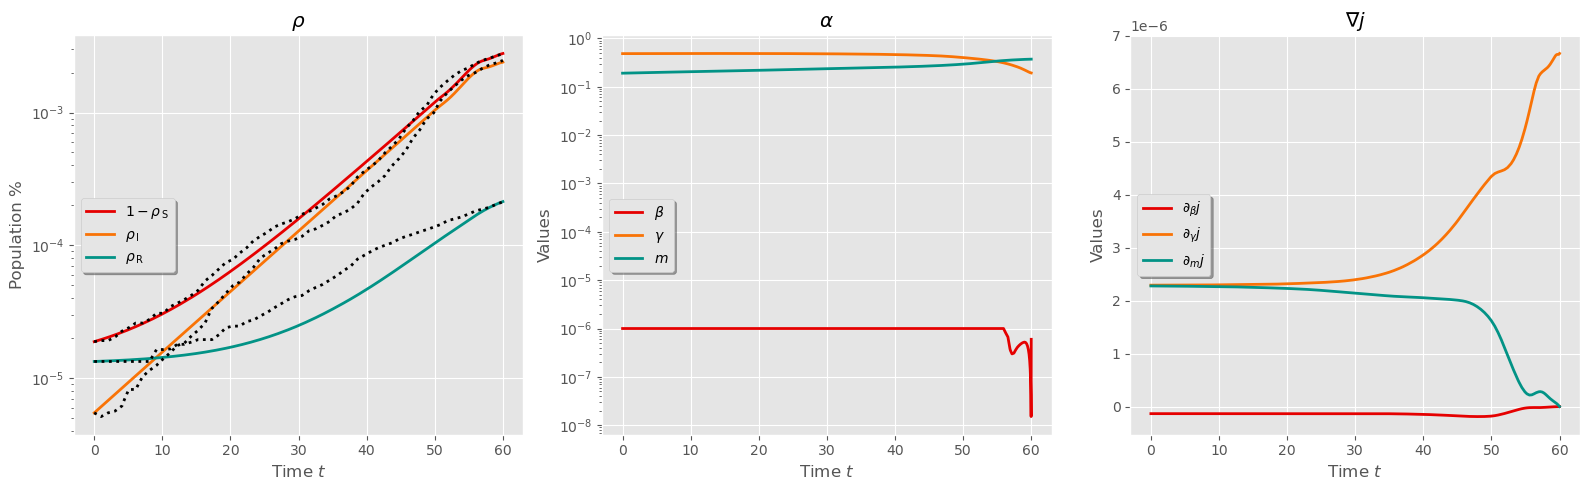

In [58]:
# Plot state 
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
colors = ['xkcd:red','xkcd:orange','xkcd:teal']

# Add state
ax[0].plot(Tₑ*7, 1 - ρ[0].T/n, '-', linewidth=2)
ax[0].plot(Tₑ*7, ρ[1:].T/n, '-', linewidth=2)
for i, line in enumerate(ax[0].get_lines()):    line.set_color(colors[i])
ax[0].legend(['$1-ρ_{\,\mathsf{S}}$', '$ρ_{\,\mathsf{I}}$', '$ρ_{\,\mathsf{R}}$'], shadow=True, loc='center left')

ax[0].plot(Tₑ*7, 1 - ρ̂[0].T/n, ':', c='black', linewidth=2)
ax[0].plot(Tₑ*7, ρ̂[1:].T/n, ':', c='black', linewidth=2)

ax[1].plot(Tₑ*7, ᾱ.data[0]*7*1e-4, '-', c='xkcd:red', linewidth=2)   #scale to original units
ax[1].plot(Tₑ*7, ᾱ.data[1]*7, '-', c='xkcd:orange', linewidth=2)
ax[1].plot(Tₑ*7, ᾱ.data[2]*7, '-', c='xkcd:teal', linewidth=2)
ax[1].legend(['$β$', '$γ$', '$m$'], shadow=True, loc='center left')

ax[2].plot(Tₑ*7, best['df'][0]*7*1e-4, '-', c='xkcd:red', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][1]*7, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2]*7, '-', c='xkcd:teal', linewidth=2)
ax[2].legend(['$\partial_β j$', '$\partial_γ j$', '$\partial_m j$'], shadow=True, loc='center left')


ax[0].set_xlabel(r'Time $t$ (days)');    ax[0].set_title(r'$\rho$')
ax[1].set_xlabel(r'Time $t$ (days)');    ax[1].set_title(r'$\alpha$')
ax[2].set_xlabel(r'Time $t$ (days)');    ax[2].set_title(r'$\nabla j$')

ax[0].set_ylabel('Population %')
ax[1].set_ylabel('Values')
ax[2].set_ylabel('Values')

ax[0].set_yscale('log')#, linthresh=1e-2)
ax[1].set_yscale('log')
#ax[1].set_ylim([1e-8, 30*ᾱ.data[2].max()])

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/DD – Panels – nmAPG.pdf', bbox_inches='tight', pad_inches=0)

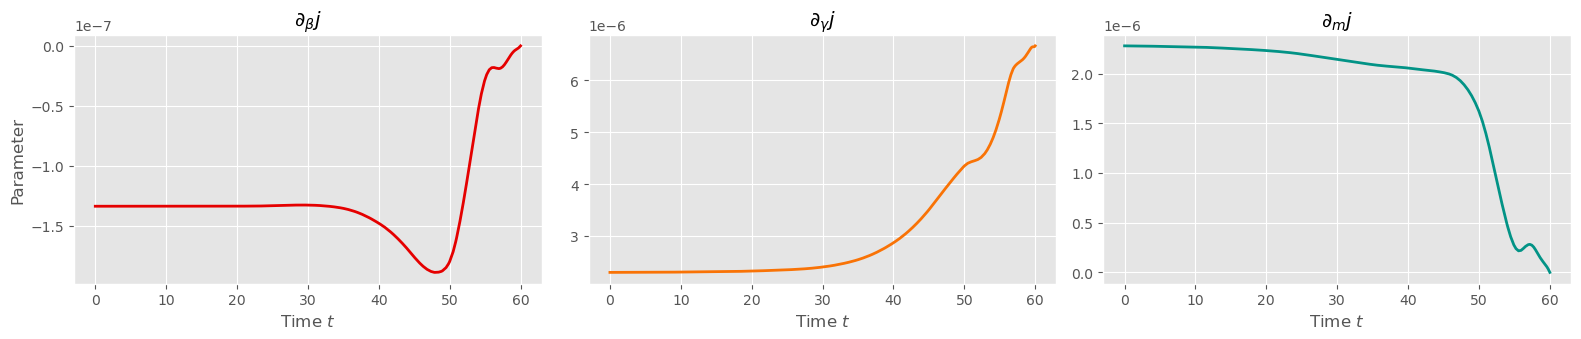

In [59]:
# Plot derivative 
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

# Add state
ax[0].plot(Tₑ*7, best['df'][0]*7*1e-4, '-', c='xkcd:red', linewidth=2)
ax[1].plot(Tₑ*7, best['df'][1]*7, '-', c='xkcd:orange', linewidth=2)
ax[2].plot(Tₑ*7, best['df'][2]*7, '-', c='xkcd:teal', linewidth=2)

ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'$\partial_\beta j$')
ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'$\partial_\gamma j$')
ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'$\partial_m j$')

ax[0].set_ylabel('Parameter')

#ax[0].set_yscale('log');    ax[1].set_yscale('log');    ax[2].set_yscale('log')

#plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
#plt.savefig('Outputs/Regularisation – States – FISTA.pdf', bbox_inches='tight', pad_inches=0)

In [60]:
(ᾱ.data[1]*7 + ᾱ.data[2]*7).max()

0.718464772639631

---

### Store

In [61]:
every_iter['obj'] = asarray(every_iter['obj'])
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/DD – nmAPG - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
996,996,5.671209e-08,39.373807,0.000972,0.000222,0.000225,6.348602e-11
997,997,5.671585e-08,39.439404,0.000972,0.000222,0.000225,6.348750e-11
998,998,5.671961e-08,39.492413,0.000973,0.000222,0.000225,6.348897e-11
999,999,5.672336e-08,39.557538,0.000960,0.000219,0.000223,6.349045e-11
1000,1000,5.672711e-08,39.625258,0.000965,0.000220,0.000222,6.349192e-11


In [62]:
# Store info from iterate with smallest objective
ArgMin_nmAPG = df_every.idxmin()['obj']
#Out_θ = 
df_every.loc[[ArgMin_nmAPG]].rename(index={ArgMin_nmAPG:θ}).copy()

,it,obj,time,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
"[[1e-06], [1e-08], [1e-09]]",648,5.485363e-08,22.284909,0.001312,0.000295,0.00027,7.067954e-11


---

In [63]:
np.savez_compressed('Outputs/DD – nmAPG – Best', best = best)

In [64]:
#np.load('Outputs/DD – nmAPG – Best.npz', allow_pickle=True)['best']

---